# WASP-80b broadband analysis
## 3b. Gaussian process hyperparameter estimation II

**Hannu Parviainen, Instituto de Astrofísica de Canarias**<br>

---

This notebook works as an appendix to Parviainen et al., *Ground based transmission spectroscopy of WASP-80b* (2017). The paper covers two analyses: a broadband analysis using three previously published datasets, and a transmission spectroscopy analysis using two GTC-observed spectroscopic time series, and this notebook covers a part of the broadband analysis.

**Last (significant) revision: 11.08.2017**

---

Here we estimate the GP HPs for the F14 dataset. The F14 dataset includes time, airmass, and x- and y-shifts as covariates.

In [1]:
%pylab inline
%run __init__.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
from exotk.utils.misc import fold
from src.extcore import *

In [3]:
lpf = LPFFukui2014(use_ldtk=True)
lpfo = LPFTM(use_ldtk=False, constant_k=True, noise='white')
pv0 = pd.read_hdf(RFILE_EXT,'ckwn_ldtk/fc').median().values

In [4]:
pv1 = zeros(lpf.ps.ndim)
pv1[:5] = pv0[:5]

if lpf.use_ldtk:
    u,v = lpf.lp.coeffs_qd()[0].T
    q1,q2 = map_uv_to_qq(u,v)
    pv1[lpf._sq1:lpf._sq1+2*lpf.npb:2] = q1
    pv1[lpf._sq2:lpf._sq2+2*lpf.npb:2] = q2
else:
    pv1[lpf._sq1:lpf._sq1+2*lpf.npb:2] = pv0[lpfo._sq1:lpfo._sq1+2*lpf.npb:2]
    pv1[lpf._sq2:lpf._sq2+2*lpf.npb:2] = pv0[lpfo._sq2:lpfo._sq2+2*lpf.npb:2]
pv1[lpf._sbl:lpf._sbl+lpf.nlc] = 1

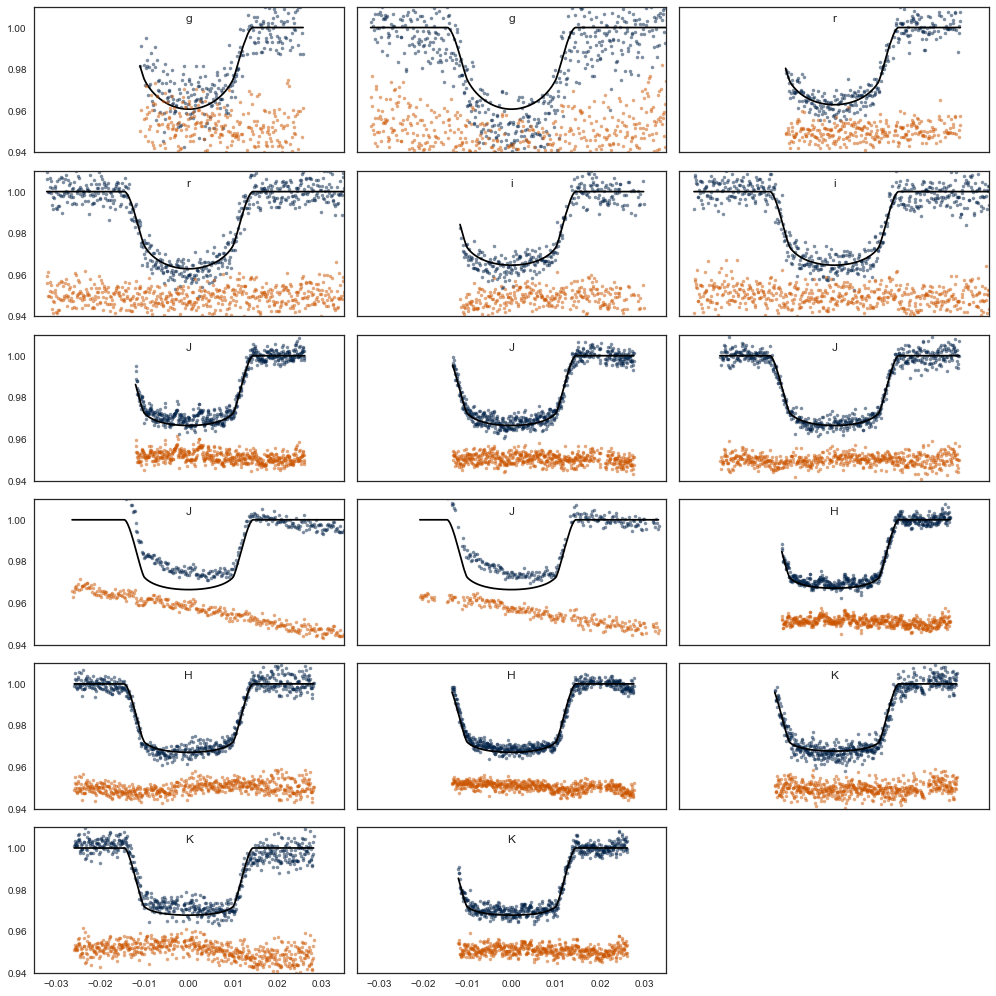

In [5]:
phases = list(map(lambda t: fold(t, P, TC, 0.5)-0.5, lpf.times))
fluxes_m = lpf.compute_lc_model(pv1)
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    a = axs.flat[iax]
    a.plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.5)
    a.plot(phases[ilc],fluxes_m[ilc],'k')
    a.plot(phases[ilc],lpf.fluxes[ilc]-fluxes_m[ilc]+0.95,'.', alpha=0.5)
    a.text(0.5, 0.95, lpf.passbands[ilc], ha='center', va='top', size=12, transform=a.transAxes)
setp(axs, ylim=(0.94,1.01), xlim=(-0.035,0.035))
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [6]:
fluxes_m = lpf.compute_transit(pv0)
residuals = [fo-fm for fo,fm in zip(lpf.fluxes,fluxes_m)]
gps = [GPF14(gpin, res) for gpin,res in zip(lpf.gp_inputs,residuals)]
hps = []

In [7]:
hps = []
for gp in tqdm(gps, desc='Optimising GP hyperparameters'):
    gp.fit()
    hps.append(gp.hp)

Optimising GP hyperparameters: 100%|██████████| 17/17 [01:54<00:00,  3.41s/it]


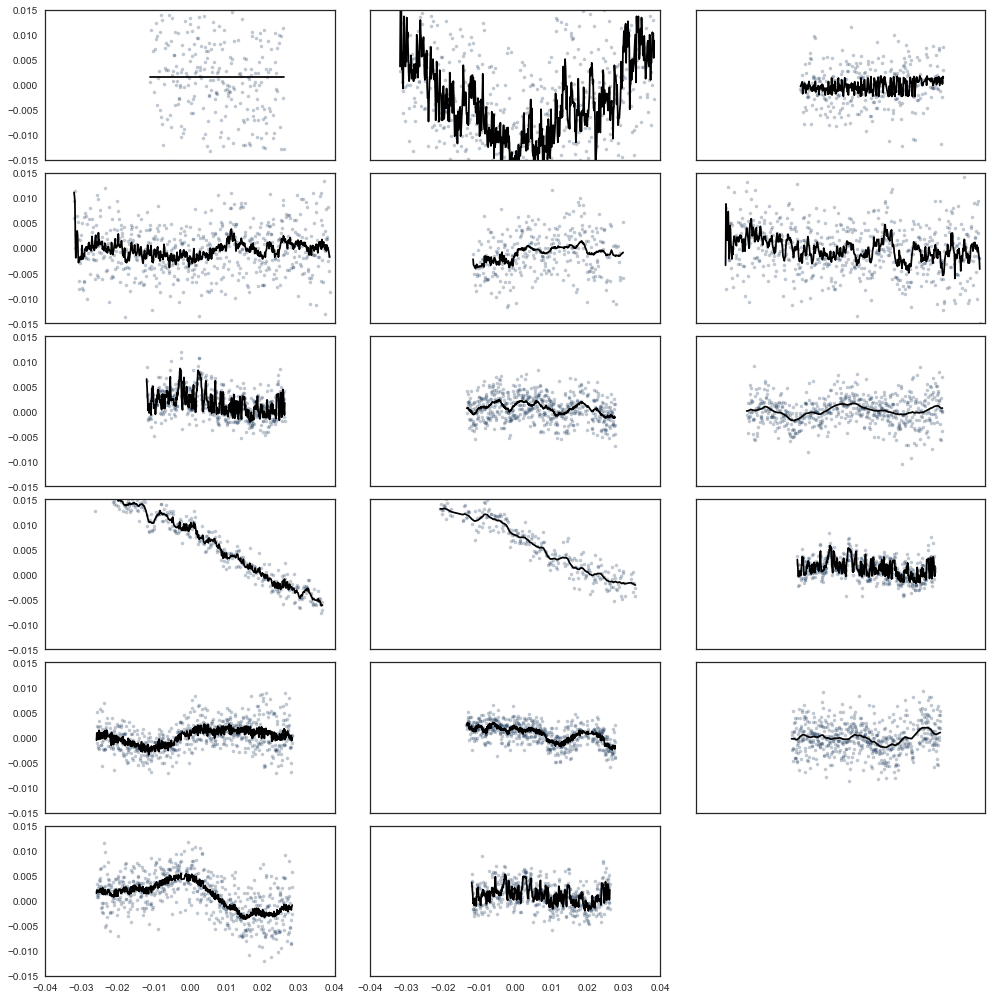

In [8]:
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    axs.flat[iax].plot(phases[ilc],gps[ilc].flux,'.', alpha=0.25)
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict(None)
    axs.flat[iax].plot(phases[ilc], pr, 'k')
setp(axs, ylim=(-0.015,.015), xlim=(-0.04,0.04))
fig.tight_layout()
axs.flat[-1].set_visible(False)

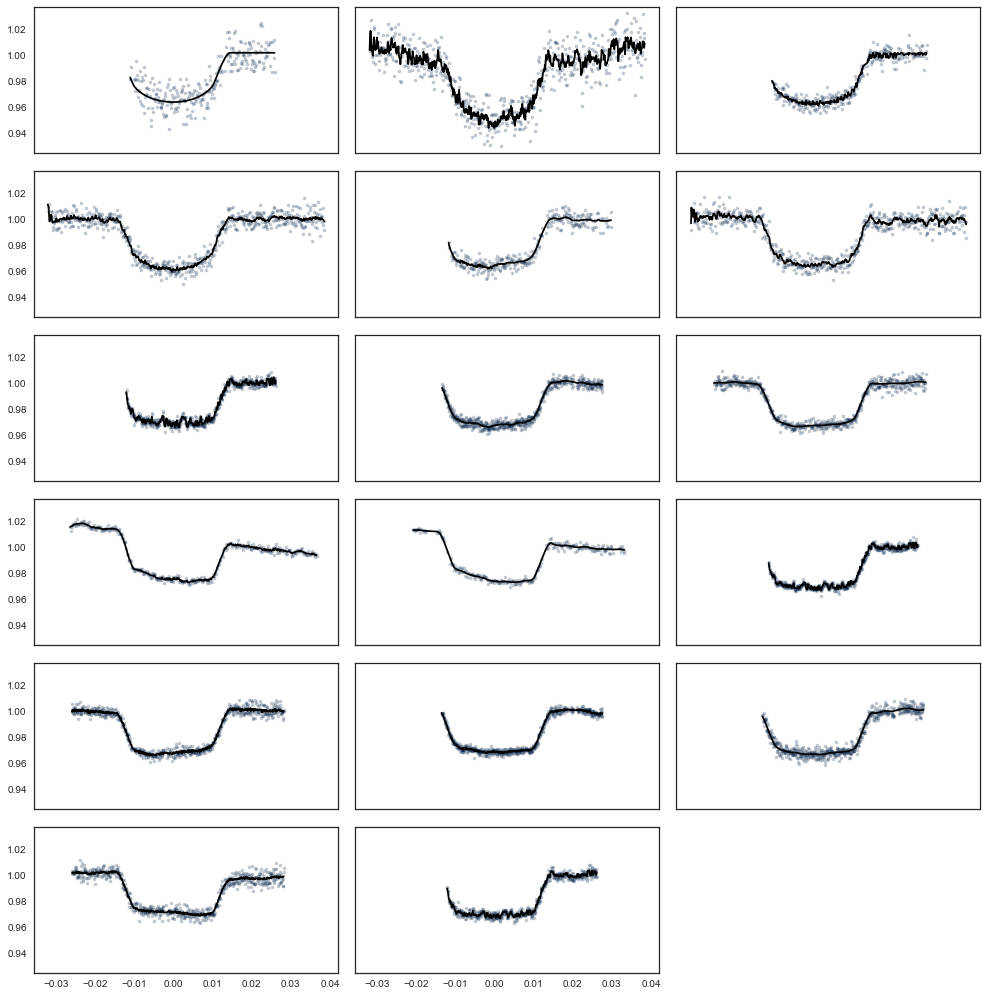

In [9]:
fig,axs = subplots(6,3, figsize=(14,14),sharey=True, sharex=True)
for iax,ilc in enumerate(lpf.lcorder):
    gps[ilc].compute(hps[ilc])
    pr = gps[ilc].predict(gps[ilc].hp)
    axs.flat[iax].plot(phases[ilc],lpf.fluxes[ilc],'.', alpha=0.25)
    axs.flat[iax].plot(phases[ilc],fluxes_m[ilc]+pr,'k')
fig.tight_layout()
axs.flat[-1].set_visible(False)

In [10]:
with pd.HDFStore(DFILE_EXT) as f:
    lcnames = [k[4:] for k in f.keys() if 'lc/fukui' in k]

df = pd.DataFrame(hps, columns=gp.names, index=lpf.passbands)
df['lc_name'] = lcnames
df

,ln_wn_var,ln_tvar,ln_tscale,ln_xyvar,ln_xscale,ln_yscale,ln_amvar,ln_amscale,lc_name
H,-13.240466,-14.395382,-8.984582,-12.933941,3.216626,2.978507,-12.188357,17.873967,fukui2014/H/irsf_130716
H,-12.911211,-12.949431,-5.951106,-16.320613,1.056538,-6.544166,-14.884892,-8.466162,fukui2014/H/irsf_130822
H,-11.963668,-13.240136,-6.833430,-13.718558,3.798473,1.776514,-34.649308,6.413295,fukui2014/H/irsf_131007
J,-12.571303,-13.702648,-6.580204,-12.015281,3.453545,4.340077,-11.595936,17.620364,fukui2014/J/irsf_130716
J,-12.074996,-13.339315,-8.743208,-17.376930,-4.760776,-1.854099,-42.163989,3.740372,fukui2014/J/irsf_130822
J,-11.870117,-13.985881,-8.520926,-31.803971,0.394000,-0.283732,-28.407577,13.468419,fukui2014/J/irsf_131007
J,-13.175909,-9.158347,-0.927555,-15.826188,-2.284426,1.914953,-9.677448,-0.653911,fukui2014/J/isle_130813
J,-12.814445,-9.394761,-0.415465,-41.313122,-0.262746,-0.725762,-28.865901,8.171075,fukui2014/J/isle_130922
K,-12.548463,-13.867436,-8.491660,-12.235958,3.844227,4.657154,-12.031461,13.202894,fukui2014/K/irsf_130716
K,-11.673347,-13.694378,-8.828305,-35.995774,-12.960047,13.165347,-26.609989,12.821339,fukui2014/K/irsf_130822


In [11]:
df.to_hdf(RFILE_EXT, 'gphp/fukui2014')

---

<center> &copy; 2017 <a href="mailto:hannu@iac.es">Hannu Parviainen</a></center>